## Cross-validation for PU and SVM models

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulearn.bagging import BaggingPuClassifier
from sklearn.base import clone
from sklearn.metrics import (
    f1_score,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    train_test_split,
)
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from lib.cv import (
    perform_cv,
)
from lib.pu import (
    BASE_MODELS,
    get_xy,
    downsample_unlabelled,
)

# Suppress FutureWarning for some versions of Scikit-learn
%env PYTHONWARNINGS=ignore::FutureWarning

warnings.simplefilter("ignore", FutureWarning)

env: PYTHONWARNINGS=ignore::FutureWarning


In [2]:
# Random seed for reproducibility
random_seed = 1234

# Number of jobs used to train models
n_jobs = 8

### Load and process training data

In [3]:
data_filename = "training_data.csv"
data = pd.read_csv(data_filename)

data = downsample_unlabelled(data, random_state=random_seed)

print(data.groupby("label").size())

label
negative      689
positive      347
unlabelled    347
dtype: int64


### Perform cross-validation

In [4]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_seed)
# Scaling not necessary for RF, but kept for consistency
scaler = RobustScaler()

thresh_pu = "auto"
base_model = clone(BASE_MODELS["randomforest"])
base_model.set_params(random_state=random_seed)
model_pu = BaggingPuClassifier(
    base_model,
    n_jobs=4,
    random_state=random_seed,
    n_estimators=250,
    max_samples=1.0,
)
model_pu = make_pipeline(scaler, model_pu)
results_pu = perform_cv(
    clf=model_pu,
    data=data,
    cv=cv,
    thresh=thresh_pu,
    random_state=random_seed,
    pu=True,
    verbose=False,
)
results_pu = pd.DataFrame(results_pu)

thresh_svm = "auto"
model_svm = SVC(kernel="rbf", probability=True, random_state=random_seed)
model_svm = make_pipeline(scaler, model_svm)

results_svm = perform_cv(
    clf=model_svm,
    data=data,
    cv=cv,
    thresh=thresh_svm,
    random_state=random_seed,
    pu=False,
    verbose=False,
)
results_svm = pd.DataFrame(results_svm)

In [5]:
print(
    pd.concat(
        (
            pd.Series(
                results_pu.mean(numeric_only=True),
                name="PU",
            ),
            pd.Series(
                results_svm.mean(numeric_only=True),
                name="SVM",
            )
        ),
        axis=1,
    )
)

                           PU         SVM
roc_auc              0.891541    0.993360
average_precision    0.893954    0.986279
balanced_accuracy    0.872229    0.973538
accuracy             0.902303    0.975287
f1                   0.842283    0.963306
n_train            496.000000  828.800000
time_fit            15.869616    0.046867
n_test             207.200000  207.200000
time_predict         4.515399    0.003729
prob_thresh          0.867273    0.389899


Text(0.5, 1.0, 'SVM')

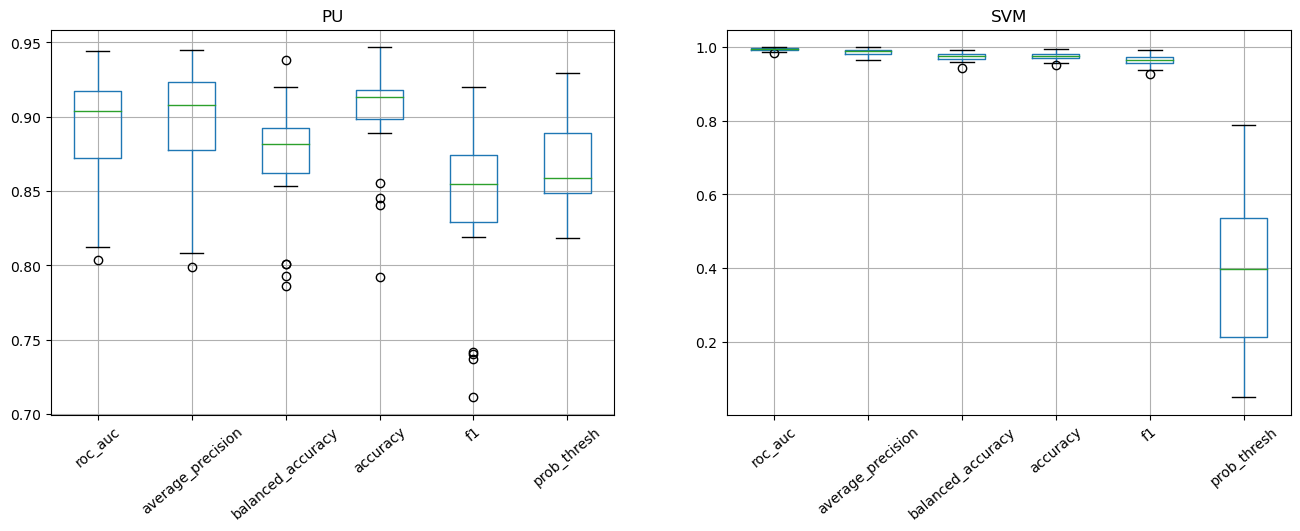

In [6]:
drop = ["n_train", "time_fit", "n_test", "time_predict"]

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
results_pu.drop(columns=drop).boxplot(ax=axs[0], rot=40)
axs[0].set_title("PU")
results_svm.drop(columns=drop).boxplot(ax=axs[1], rot=40)
axs[1].set_title("SVM")

### Performance varies by region

In [7]:
# Compare test performance for North and South America

stratify = (
    data["region"]
    + "_"
    + data["label"]
)
data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    random_state=random_seed,
    shuffle=True,
    stratify=stratify,
)
data_test = data_test[data_test["label"].isin({"positive", "negative"})]
test_NA = data_test[data_test["region"] == "NAm"]
test_SA = data_test[data_test["region"] == "SAm"]

train_pu = data_train[
    data_train["label"].isin({"positive", "unlabeled", "unlabelled"})
]
x_train_pu, y_train_pu = get_xy(train_pu)
train_svm = data_train[
    data_train["label"].isin({"positive", "negative"})
]
x_train_svm, y_train_svm = get_xy(train_svm)

x_test, y_test = get_xy(data_test)
x_test_NA, y_test_NA = get_xy(test_NA)
x_test_SA, y_test_SA = get_xy(test_SA)

model_pu = clone(model_pu)
model_pu.fit(x_train_pu, y_train_pu)

model_svm = clone(model_svm)
model_svm.fit(x_train_svm, y_train_svm)

probs_pu = model_pu.predict_proba(x_test)[:, 1]
probs_pu_NA = model_pu.predict_proba(x_test_NA)[:, 1]
probs_pu_SA = model_pu.predict_proba(x_test_SA)[:, 1]

probs_svm = model_svm.predict_proba(x_test)[:, 1]
probs_svm_NA = model_svm.predict_proba(x_test_NA)[:, 1]
probs_svm_SA = model_svm.predict_proba(x_test_SA)[:, 1]

In [8]:
print(
    pd.concat(
        (
            data_train.assign(set="train"),
            data_test.assign(set="test"),
        )
    ).groupby(["set", "region", "label"]).size()
)

set    region  label     
test   NAm     negative       11
               positive       44
       SAm     negative      127
               positive       26
train  NAm     negative       46
               positive      173
               unlabelled     68
       SAm     negative      505
               positive      104
               unlabelled     54
       other   unlabelled    156
dtype: int64


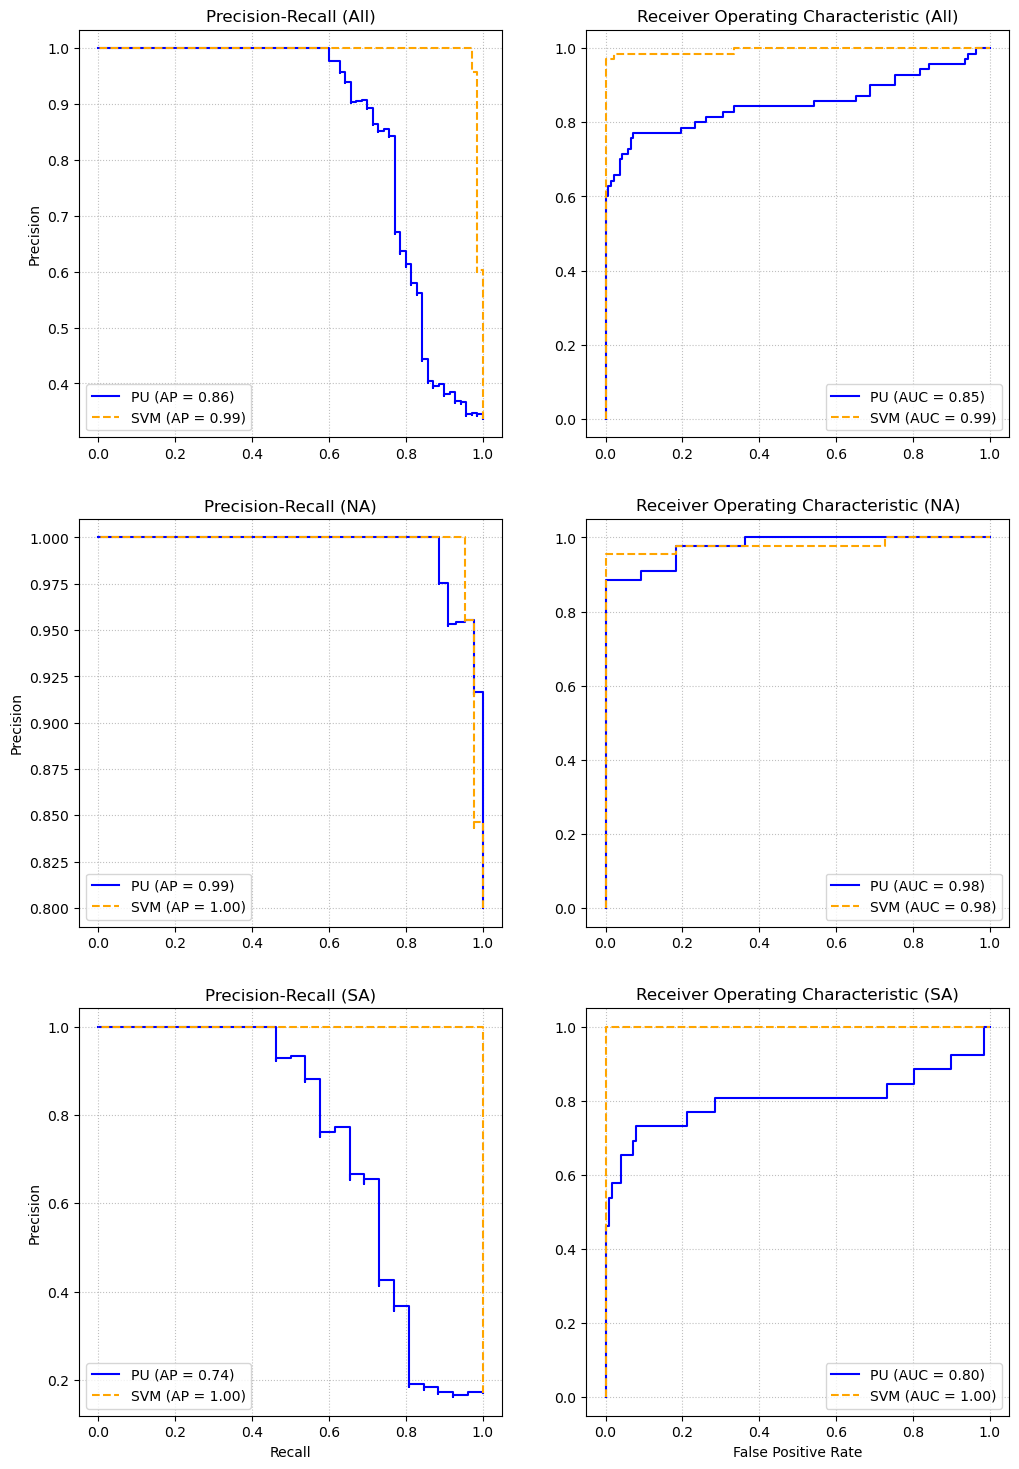

In [9]:
regions = ("All", "NA", "SA")
values_dict = {
    "All": y_test,
    "NA": y_test_NA,
    "SA": y_test_SA,
}
probs_dict = {
    "All": {"PU": probs_pu, "SVM": probs_svm},
    "NA": {"PU": probs_pu_NA, "SVM": probs_svm_NA},
    "SA": {"PU": probs_pu_SA, "SVM": probs_svm_SA},
}
kwargs_dict = {
    "PU": {"color": "blue", "linestyle": "solid"},
    "SVM": {"color": "orange", "linestyle": "dashed"},
}
titles_dict = {
    PrecisionRecallDisplay: "Precision-Recall",
    RocCurveDisplay: "Receiver Operating Characteristic",
}

fig, axs = plt.subplots(3, 2, figsize=(12, 18))
for i, region in enumerate(regions):
    row = axs[i]
    values = values_dict[region]
    probs = probs_dict[region]
    for j, (ax, which) in enumerate(
        zip(
            row,
            (
                PrecisionRecallDisplay,
                RocCurveDisplay,
            ),
        )
    ):
        for model in ("PU", "SVM"):
            which.from_predictions(
                values,
                probs[model],
                name=model,
                ax=ax,
                **(kwargs_dict[model]),
            )
        ax.grid(
            linestyle="dotted",
            color="grey",
            alpha=0.5,
        )
        ax.set_title(f"{titles_dict[which]} ({region})")
        if i == 2:
            ax.set_xlabel(
                ax.get_xlabel().replace(
                    " (Positive label: 1)",
                    "",
                )
            )
        else:
            ax.set_xlabel("")
        if j == 0:
            ax.set_ylabel(
                ax.get_ylabel().replace(
                    " (Positive label: 1)",
                    "",
                )
            )
        else:
            ax.set_ylabel("")

### Determine the optimal probability threshold

PU: optimal threshold = 0.85
SVM: optimal threshold = 0.39


Text(0.5, 1.0, '$\\mathrm{F_1}$ score v. probability threshold')

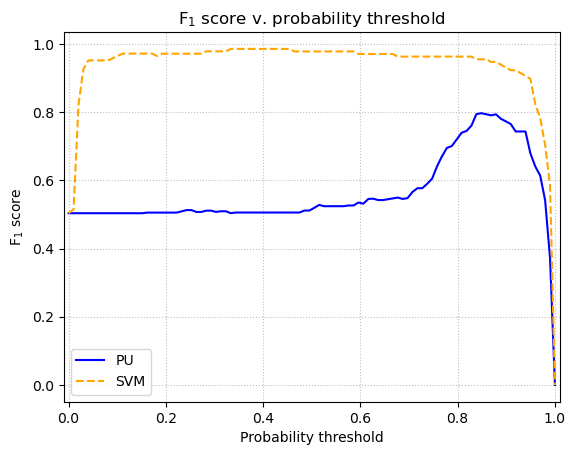

In [10]:
score_func = f1_score
thresholds = np.linspace(0, 1, 100)

fig, ax = plt.subplots(1, 1)
for model in ("PU", "SVM"):
    probs = probs_dict["All"][model]
    scores = np.zeros_like(thresholds)
    for i, threshold in enumerate(thresholds):
        score = score_func(y_test, probs >= threshold)
        scores[i] = score
    ax.plot(thresholds, scores, label=model, **(kwargs_dict[model]))
    opt_value = np.median(thresholds[scores == np.nanmax(scores)])
    print(f"{model}: optimal threshold = {opt_value:0.2f}")

ax.set_xlim(-0.01, 1.01)
ax.grid(
    linestyle="dotted",
    color="grey",
    alpha=0.5,
)
ax.legend()
ax.set_xlabel("Probability threshold")
ylabel = r"$\mathrm{F_1}$ score"
ax.set_ylabel(ylabel)
ax.set_title(f"{ylabel} v. probability threshold")